In [ ]:
# imported required packages. Add the one you need.
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from PIL import Image

import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# import packages for building sequential model
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Video/Images Classification

In [ ]:
# TODO 1
# Create training and testing dataset from the image files
# Transform your images before creating data loaders
from image_dataloader import GestureSequenceDataset

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 64x64 pixels
    transforms.ToTensor(),         # Image to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize the image
])

# Get the datasets
train_dataset = GestureSequenceDataset(root_dir='../dataset/train', transform=transform)
val_dataset = GestureSequenceDataset(root_dir='../dataset/val', transform=transform)

# Print the size of the datasets
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

Training dataset size: 663
Validation dataset size: 100


In [77]:
class GestureRecognitionModel(nn.Module):
    def __init__(self, num_classes):
        super(GestureRecognitionModel, self).__init__()

        # TODO 2: construct your own model. CNNs+LSTM is recommended

        # Convolutional Neural Network (CNN)
        # https://www.datacamp.com/tutorial/convolutional-neural-networks-python
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1), # Input: (3, 64, 64) RBG image
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # LSTM for sequence processing
        self.lstm = nn.LSTM(32 * 16 * 16, 128, batch_first=True)
        
        # Fully connected layer for classification
        self.fc = nn.Linear(128, num_classes)


    def forward(self, x):
        batch_size, seq_len, c, h, w = x.size()  # Shape: (batch_size, seq_len, c, h, w)

        # TODO 3: write your feed forward network
        # Pass each frame through the CNN
        c_in = x.view(batch_size * seq_len, c, h, w)
        c_out = self.cnn(c_in)
        c_out = c_out.view(batch_size, seq_len, -1)  # Reshape for LSTM
        
        # Pass through LSTM
        r_out, (h_n, h_c) = self.lstm(c_out)
        
        # Pass the final hidden state through the FC layer
        r_out2 = self.fc(r_out[:, -1, :])
        return r_out2

In [78]:
# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the model, loss function, and optimizer
model = GestureRecognitionModel(num_classes=5).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # learning rate

Using device: cuda


In [ ]:
# TODO 4: train your model with sequnce of images, you should aim for at least
# 45% training accuracy. Report your training accuracy.


num_epochs = 5 # set the number of epochs for training

for epoch in range(num_epochs):
    # Init variables
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Loop over each batch
    for i, (sequences, labels) in enumerate(train_loader):
        sequences, labels = sequences.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(sequences)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Optimize the model
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        running_loss += loss.item()

    # Print statistics for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

    # it is recommand to save the model regulary during training if you don't have a lof of computational resource
    model_path = os.path.join('..', 'trained_models', f'model_{epoch+1}.pth')
    torch.save(model.state_dict(), model_path)
    print(f"Model saved at {model_path}")


Epoch [1/5], Loss: 1.4440, Accuracy: 37.25%
Model saved at .\model_configs\image_lstm_model_1.pth
Epoch [2/5], Loss: 1.1163, Accuracy: 57.01%
Model saved at .\model_configs\image_lstm_model_2.pth
Epoch [3/5], Loss: 0.9169, Accuracy: 65.16%
Model saved at .\model_configs\image_lstm_model_3.pth
Epoch [4/5], Loss: 0.7049, Accuracy: 76.17%
Model saved at .\model_configs\image_lstm_model_4.pth
Epoch [5/5], Loss: 0.5503, Accuracy: 82.50%
Model saved at .\model_configs\image_lstm_model_5.pth


In [ ]:
# TODO 5
# create test data loader
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# Load the specified trained model (if you have saved muliple checkpoint during training)
model = GestureRecognitionModel(num_classes=5)
model.load_state_dict(torch.load("../trained_models/model_1.pth"))  # Load the desired saved model weights, change the path if needed
model.eval()  # Set the model to evaluation mode


GestureRecognitionModel(
  (cnn): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(8192, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=5, bias=True)
)

Precision: 0.6354, Recall: 0.6300, F1 Score: 0.6161, Accuracy: 0.6300
Confusion Matrix:


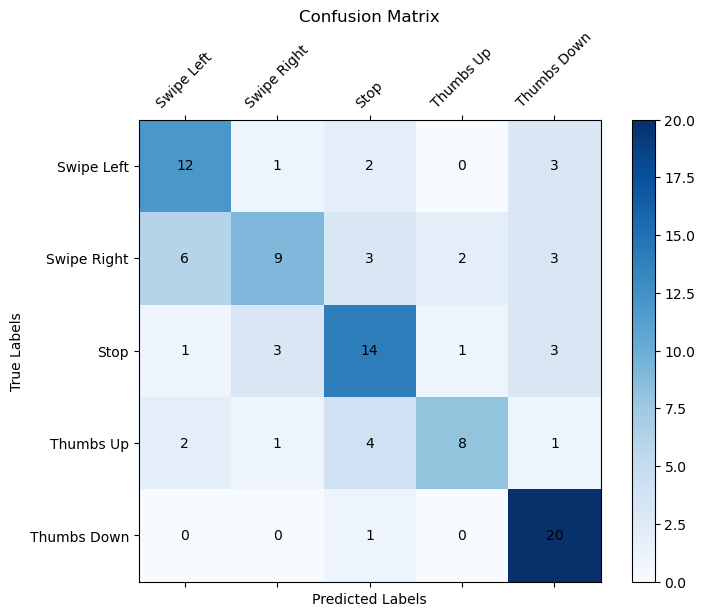

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

y_true = []
y_pred = []

# TODO 6: evaluate your model on the test dataset
with torch.no_grad():
    for sequences, labels in test_loader:
        sequences, labels = sequences.to(device), labels.to(device)
        outputs = model(sequences)

        # Get the predicted class label
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())



# TODO 7: Report precision, recall, accuracy, F1 score, and create a confusion matrix on the test set, showing the confusions between labels.
# Calculate metrics
# https://stackoverflow.com/questions/31421413/how-to-compute-precision-recall-accuracy-and-f1-score-for-the-multiclass-case
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
accuracy = (np.array(y_true) == np.array(y_pred)).mean()

# Print metrics
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}")

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
class_labels = ["Swipe Left", "Swipe Right", "Stop", "Thumbs Up", "Thumbs Down"]

# Plot confusion matrix
# https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
print("Confusion Matrix:")

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Display the confusion matrix as an image
cax = ax.matshow(conf_matrix, cmap="Blues")

# Add a colorbar
fig.colorbar(cax)

# Set labels for the axes
ax.set_xticks(np.arange(len(class_labels)))
ax.set_yticks(np.arange(len(class_labels)))
ax.set_xticklabels(class_labels, rotation=45)
ax.set_yticklabels(class_labels)

# Label the axes
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_title("Confusion Matrix")

# Add text annotations
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        ax.text(j, i, conf_matrix[i, j], ha="center", va="center", color="black")

plt.show()

# visulization helper for images

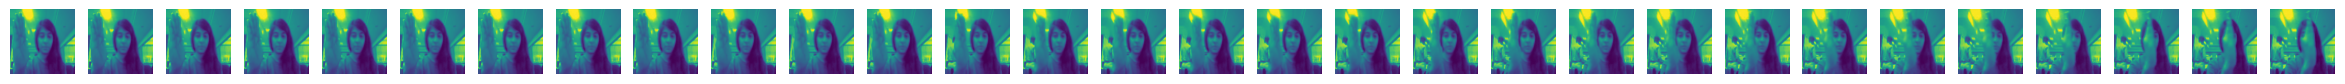

In [ ]:
# Visualize multiple frames from the sequence
frames_to_display = 30  # Number of frames to visualize
test_dataset_root = 'data/val'  # Path to the test dataset

# Get the list of subfolders (video sequences) in the test dataset
subfolders = sorted(os.listdir(test_dataset_root))

# Select a specific subfolder (e.g., the 90th subfolder)
folder_index = 90  # Change this index to visualize a different sequence
folder_name = subfolders[folder_index]
image_folder_path = os.path.join(test_dataset_root, folder_name)

# Get the list of image files in the selected subfolder
image_names = sorted(os.listdir(image_folder_path))

# Create a figure to display the frames
fig, axes = plt.subplots(1, frames_to_display, figsize=(30, 10))

# Load and display each frame
for i in range(frames_to_display):

    image_path = os.path.join(image_folder_path, image_names[i])
    # print(image_path)
    # Open and transform the image
    image = Image.open(image_path).convert("L")
    image_tensor = transform(image)
    image_np = image_tensor.numpy().transpose(1, 2, 0)

    # Plot image
    axes[i].imshow(image_np)
    axes[i].axis('off')  # Hide axis for clarity
